In [ ]:

!pip install -q pandas numpy scikit-learn matplotlib seaborn joblib

import warnings
warnings.filterwarnings('ignore')

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib

RANDOM_STATE = 42
pd.set_option('display.max_columns', 120)


In [ ]:

from google.colab import files
uploaded = files.upload()


DATA_PATH = list(uploaded.keys())[0]
df_raw = pd.read_csv(DATA_PATH)
print("Shape:", df_raw.shape)
df_raw.head()


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (1).csv
Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
def to_snake(name: str) -> str:
    name = name.strip()
    name = re.sub(r"[\s/\-]+", "_", name)
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    s2 = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1)
    return s2.lower()

df = df_raw.copy()
df.columns = [to_snake(c) for c in df.columns]

if 'total_charges' in df.columns:
    df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')


service_cols = [
    'online_security','online_backup','device_protection',
    'tech_support','streaming_tv','streaming_movies','multiple_lines'
]
for c in service_cols:
    if c in df.columns:
        df[c] = df[c].replace({'No internet service':'No', 'No phone service':'No'})


df['churn'] = df['churn'].map({'Yes':1, 'No':0}).astype(np.int32)


df = df.drop_duplicates()
print("Final shape:", df.shape)

Final shape: (7043, 21)


In [ ]:
target_col = 'churn'
id_cols = [c for c in df.columns if c.lower() in ('customerid','customer_id')]

X = df.drop(columns=[target_col] + id_cols) if id_cols else df.drop(columns=[target_col])
y = df[target_col]


numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)


df.isna().sum().sort_values(ascending=False).head(10)


Numeric cols: ['senior_citizen', 'tenure', 'monthly_charges', 'total_charges']
Categorical cols: ['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method']


,0
total_charges,11
gender,0
senior_citizen,0
partner,0
customer_id,0
dependents,0
tenure,0
multiple_lines,0
phone_service,0
online_security,0


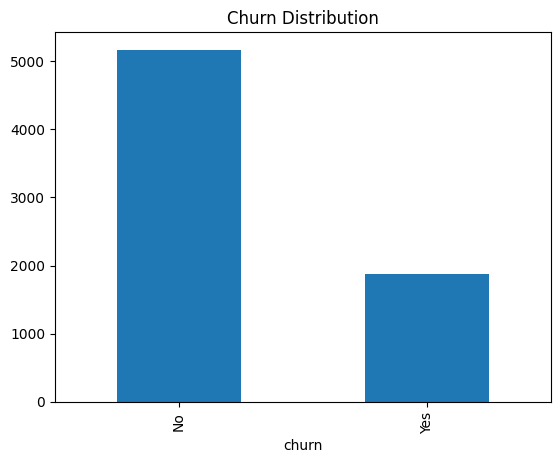

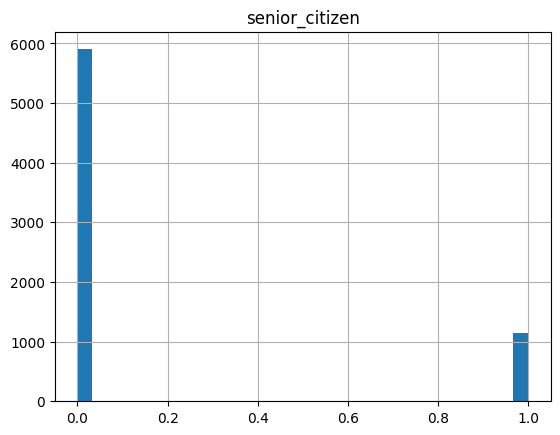

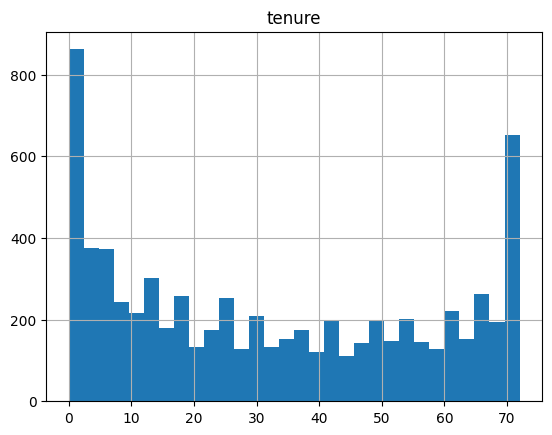

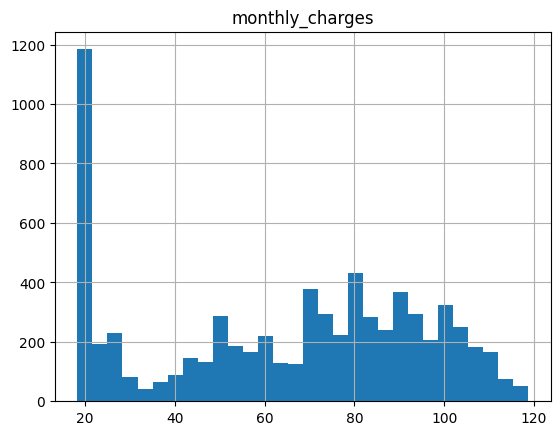

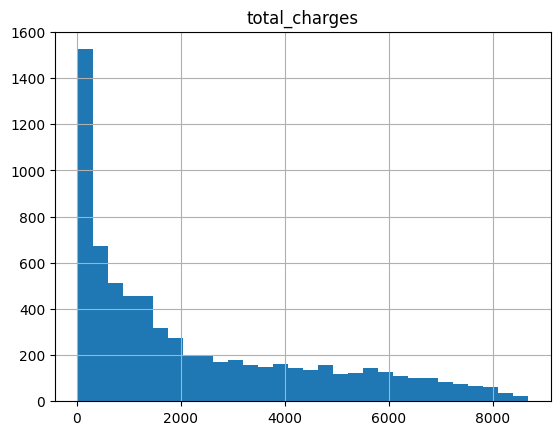

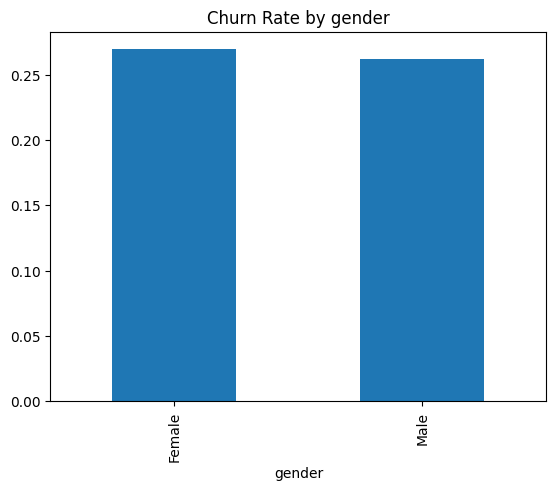

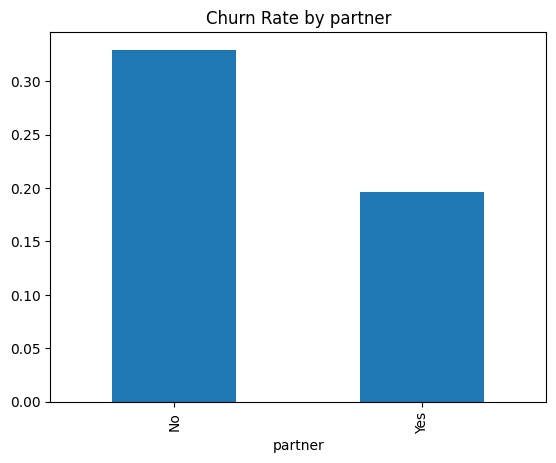

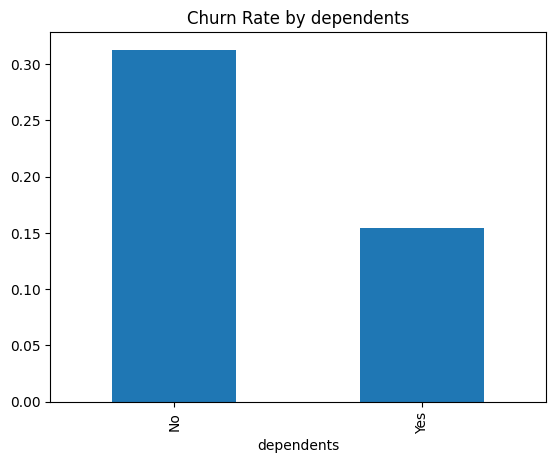

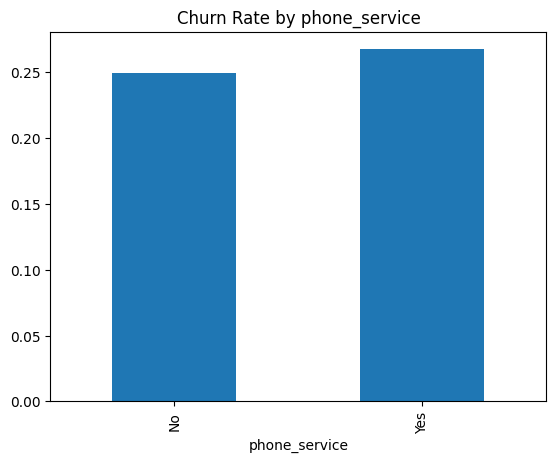

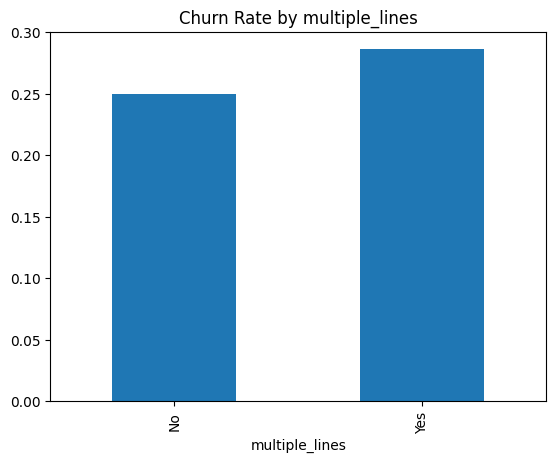

In [ ]:

y.value_counts().rename({0:'No',1:'Yes'}).plot(kind='bar')
plt.title("Churn Distribution")
plt.show()


for c in numeric_cols:
    df[c].hist(bins=30)
    plt.title(c)
    plt.show()

for c in categorical_cols[:5]:
    churn_rate = df.groupby(c)[target_col].mean()
    churn_rate.plot(kind='bar')
    plt.title(f"Churn Rate by {c}")
    plt.show()


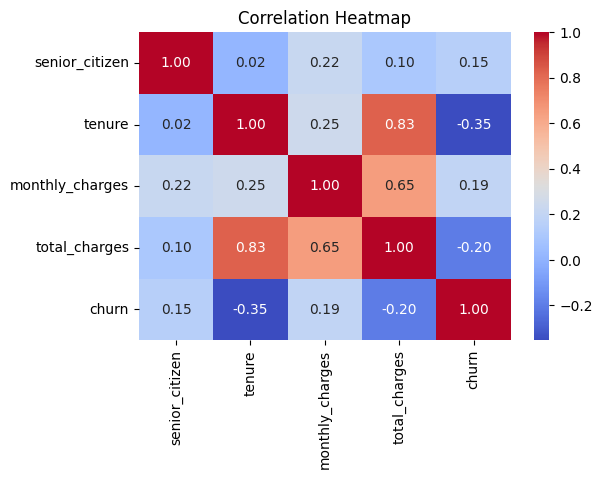

In [ ]:
num_df = df[numeric_cols + [target_col]]
plt.figure(figsize=(6,4))
sns.heatmap(num_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_cols),
    ('cat', cat_pipe, categorical_cols)
])

X_prepared = preprocessor.fit_transform(X)
print("Prepared features shape:", X_prepared.shape)


Prepared features shape: (7043, 38)


In [ ]:
os.makedirs("artifacts_day1", exist_ok=True)


df.to_csv("artifacts_day1/clean_raw.csv", index=False)


joblib.dump(preprocessor, "artifacts_day1/preprocessor.pkl")


feature_names = numeric_cols + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))
feat_df = pd.DataFrame(X_prepared, columns=feature_names)
feat_df[target_col] = y.values
feat_df.to_csv("artifacts_day1/features_onehot.csv", index=False)

print("Saved artifacts in artifacts_day1/")


Saved artifacts in artifacts_day1/


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


X = df.drop(['churn', 'customer_id'], axis=1)
y = df['churn']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)])

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
}

results = {}
for name, model in models.items():

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])


    pipeline.fit(X_train, y_train)


    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]


    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_proba)
    }


    print(f"\n{name} Results:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"Precision: {results[name]['precision']:.4f}")
    print(f"Recall: {results[name]['recall']:.4f}")
    print(f"F1-Score: {results[name]['f1']:.4f}")
    print(f"AUC: {results[name]['auc']:.4f}")


Logistic Regression Results:
Accuracy: 0.7381
Precision: 0.5043
Recall: 0.7834
F1-Score: 0.6136
AUC: 0.8416

Random Forest Results:
Accuracy: 0.7757
Precision: 0.5993
Recall: 0.4679
F1-Score: 0.5255
AUC: 0.8201

XGBoost Results:
Accuracy: 0.7594
Precision: 0.5378
Recall: 0.6658
F1-Score: 0.5950
AUC: 0.8258


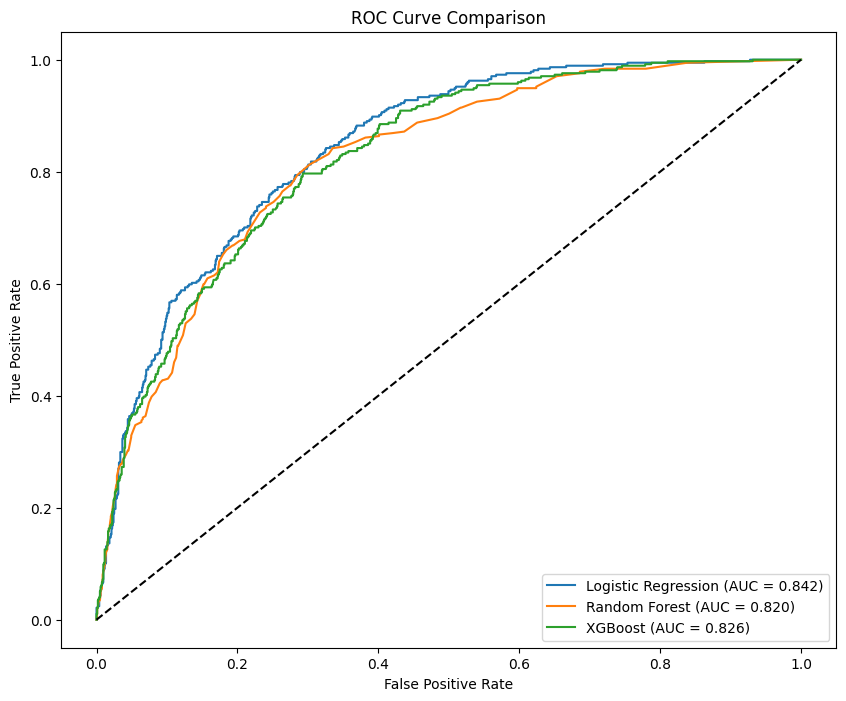

In [ ]:
plt.figure(figsize=(10, 8))
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


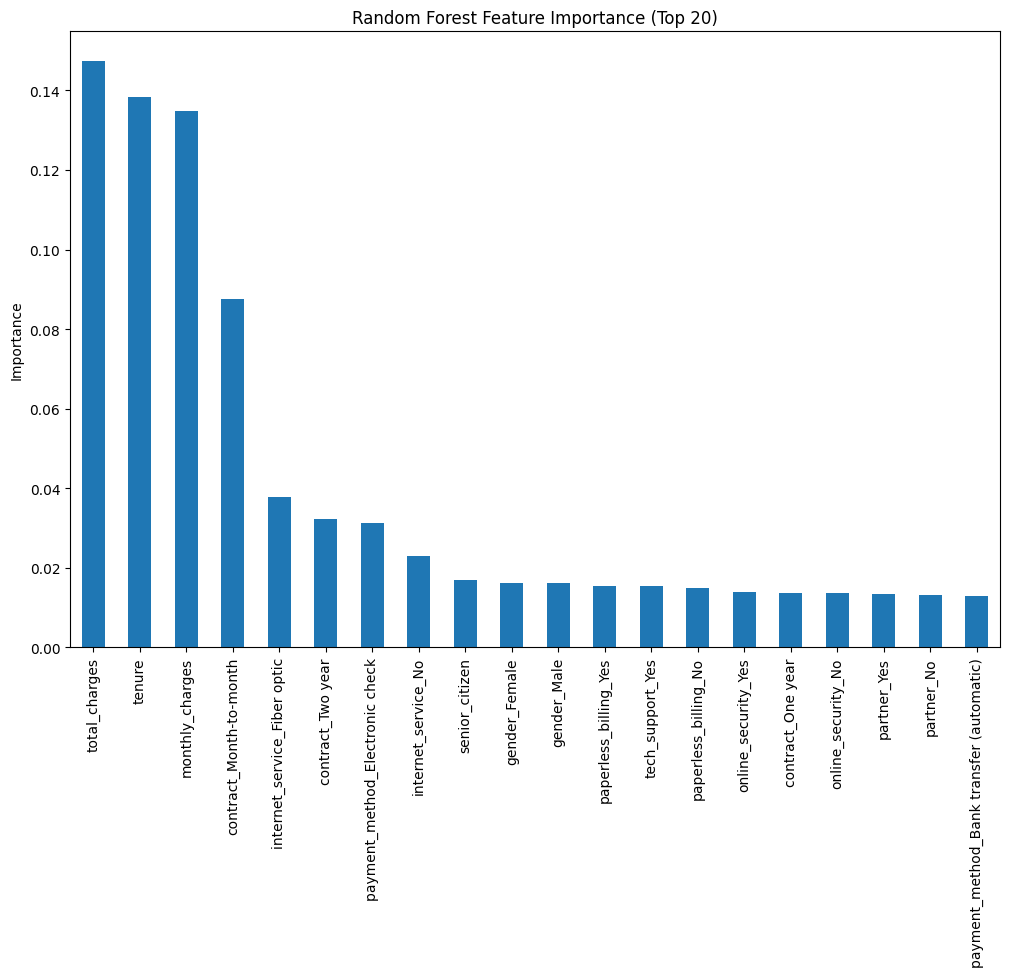


Model Comparison:
                     accuracy  precision    recall        f1       auc
Logistic Regression  0.738112   0.504303  0.783422  0.613613  0.841634
Random Forest        0.775727   0.599315  0.467914  0.525526  0.820083
XGBoost              0.759404   0.537797  0.665775  0.594982  0.825780


In [ ]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', models['Random Forest'])])
rf_pipeline.fit(X_train, y_train)


preprocessor.fit(X_train)
feature_names = (numeric_cols +
                 list(rf_pipeline.named_steps['preprocessor']
                      .named_transformers_['cat']
                      .named_steps['onehot']
                      .get_feature_names_out(categorical_cols)))


importances = rf_pipeline.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feat_imp.head(20).plot(kind='bar')
plt.title('Random Forest Feature Importance (Top 20)')
plt.ylabel('Importance')
plt.show()


results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
target_col = 'churn'
id_cols = [c for c in df.columns if c.lower() in ('customerid','customer_id')]

X = df.drop(columns=[target_col] + id_cols) if id_cols else df.drop(columns=[target_col])
y = df[target_col]

In [ ]:
numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])



In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [ ]:
X_processed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)


X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (5634, 38, 1)
X_test shape: (1409, 38, 1)


In [ ]:
def create_mlp_model(hidden_units=64, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential([
        Dense(hidden_units, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    return model

In [ ]:
best_auc = 0
best_params = {}
best_model = None

In [ ]:

param_grid = {
    'hidden_units': [32, 64, 128],
    'dropout_rate': [0.3, 0.5],
    'learning_rate': [0.001, 0.0001]
}


In [ ]:
print("Starting hyperparameter tuning...")
for units in param_grid['hidden_units']:
    for dropout in param_grid['dropout_rate']:
        for lr in param_grid['learning_rate']:
            print(f"Testing params: units={units}, dropout={dropout}, lr={lr}")

            model = create_mlp_model(
                hidden_units=units,
                dropout_rate=dropout,
                learning_rate=lr
            )

            early_stop = EarlyStopping(
                monitor='val_auc',
                patience=10,
                mode='max',
                restore_best_weights=True,
                verbose=0
            )

            history = model.fit(
                X_train, y_train,
                validation_split=0.2,
                epochs=100,
                batch_size=32,
                callbacks=[early_stop],
                verbose=0
            )


Starting hyperparameter tuning...
Testing params: units=32, dropout=0.3, lr=0.001
Testing params: units=32, dropout=0.3, lr=0.0001
Testing params: units=32, dropout=0.5, lr=0.001
Testing params: units=32, dropout=0.5, lr=0.0001
Testing params: units=64, dropout=0.3, lr=0.001
Testing params: units=64, dropout=0.3, lr=0.0001
Testing params: units=64, dropout=0.5, lr=0.001
Testing params: units=64, dropout=0.5, lr=0.0001
Testing params: units=128, dropout=0.3, lr=0.001
Testing params: units=128, dropout=0.3, lr=0.0001
Testing params: units=128, dropout=0.5, lr=0.001
Testing params: units=128, dropout=0.5, lr=0.0001


In [ ]:

            val_auc = max(history.history['val_auc'])
            print(f"Validation AUC: {val_auc:.4f}")

            if val_auc > best_auc:
                best_auc = val_auc
                best_params = {'units': units, 'dropout': dropout, 'lr': lr}
                best_model = model
                print("New best parameters found!")

print(f"\nBest parameters: {best_params}")
print(f"Best validation AUC: {best_auc:.4f}")


Validation AUC: 0.8278
New best parameters found!

Best parameters: {'units': 128, 'dropout': 0.5, 'lr': 0.0001}
Best validation AUC: 0.8278


In [ ]:
print("\nTraining final model with best parameters...")
final_model = create_mlp_model(
    hidden_units=best_params['units'],
    dropout_rate=best_params['dropout'],
    learning_rate=best_params['lr']
)

early_stop = EarlyStopping(
    monitor='val_auc',
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

history = final_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=35,
    callbacks=[early_stop],
    verbose=1
)


Training final model with best parameters...
Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6317 - auc: 0.5534 - loss: 0.6380 - val_accuracy: 0.7409 - val_auc: 0.7298 - val_loss: 0.5334
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7328 - auc: 0.6960 - loss: 0.5342 - val_accuracy: 0.7542 - val_auc: 0.7900 - val_loss: 0.4920
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7319 - auc: 0.7518 - loss: 0.5134 - val_accuracy: 0.7666 - val_auc: 0.8057 - val_loss: 0.4696
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7777 - auc: 0.7988 - loss: 0.4637 - val_accuracy: 0.7808 - val_auc: 0.8114 - val_loss: 0.4573
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7816 - auc: 0.8123 - loss: 0.4517 - val_accuracy: 0.7879 - val_auc: 0.8143 - val_loss: 0.4500
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7782 - auc: 0.8152 - loss: 0.4642 - val_accuracy: 0.7915 - val_auc: 0.8158 - val_l

In [ ]:
print("\nEvaluating model on test set...")
test_loss, test_accuracy, test_auc = final_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Evaluating model on test set...
Test Loss: 0.4223
Test Accuracy: 0.7991
Test AUC: 0.8403


In [ ]:
y_pred_proba = final_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



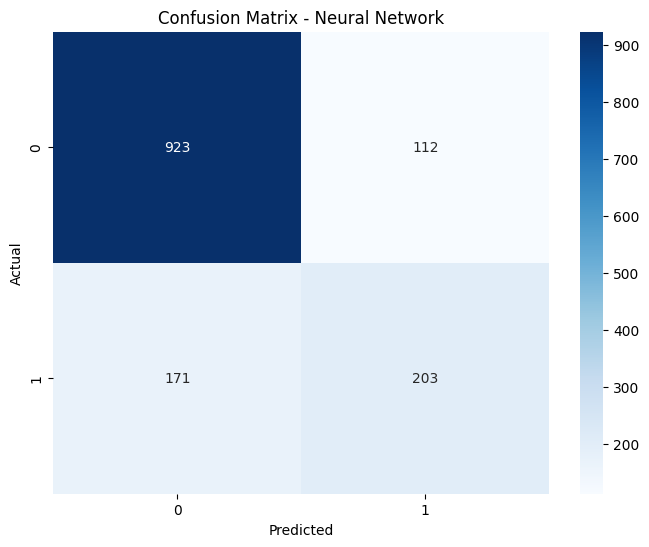

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Neural Network')
plt.show()


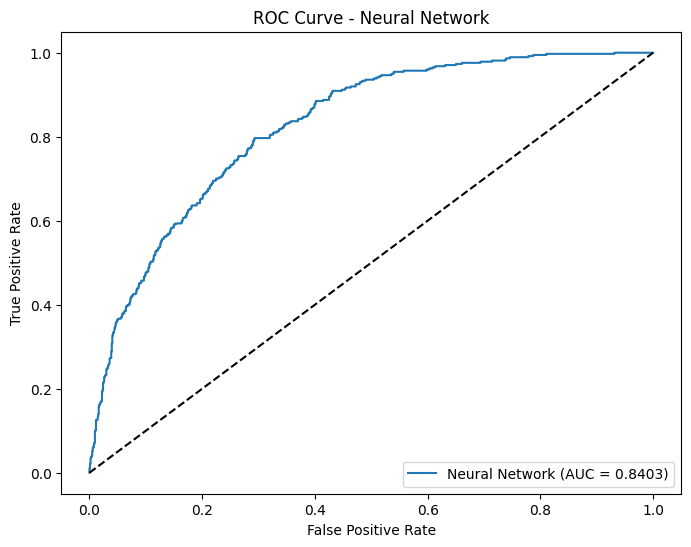

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Neural Network (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


lr_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
rf_model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)


print("Training Logistic Regression...")
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred_proba)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Logistic Regression AUC: {lr_auc:.4f}")


print("Training Random Forest...")
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Random Forest AUC: {rf_auc:.4f}")

Training Logistic Regression...
Logistic Regression Accuracy: 0.8034
Logistic Regression AUC: 0.8421
Training Random Forest...
Random Forest Accuracy: 0.7807
Random Forest AUC: 0.8202


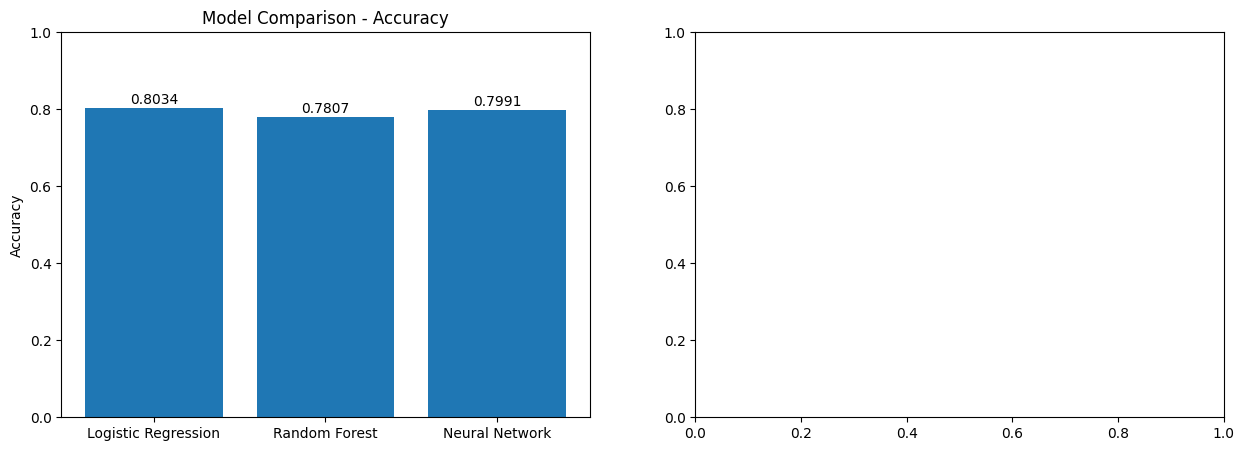

In [ ]:
models_comparison = {
    'Logistic Regression': {'Accuracy': lr_accuracy, 'AUC': lr_auc},
    'Random Forest': {'Accuracy': rf_accuracy, 'AUC': rf_auc},
    'Neural Network': {'Accuracy': test_accuracy, 'AUC': test_auc}
}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


models = list(models_comparison.keys())
accuracies = [models_comparison[model]['Accuracy'] for model in models]
ax1.bar(models, accuracies)
ax1.set_title('Model Comparison - Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for i, v in enumerate(accuracies):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center')

In [ ]:
auc_scores = [models_comparison[model]['AUC'] for model in models]
ax2.bar(models, auc_scores)
ax2.set_title('Model Comparison - AUC')
ax2.set_ylabel('AUC')
ax2.set_ylim(0, 1)
for i, v in enumerate(auc_scores):
    ax2.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()


print("\nModel Performance Comparison:")
print("=" * 50)
for model, metrics in models_comparison.items():
    print(f"{model}:")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")
    print(f"  AUC: {metrics['AUC']:.4f}")
    print("-" * 30)


<Figure size 640x480 with 0 Axes>


Model Performance Comparison:
Logistic Regression:
  Accuracy: 0.8034
  AUC: 0.8421
------------------------------
Random Forest:
  Accuracy: 0.7807
  AUC: 0.8202
------------------------------
Neural Network:
  Accuracy: 0.7991
  AUC: 0.8417
------------------------------


Model saved as 'churn_mlp_model.h5'


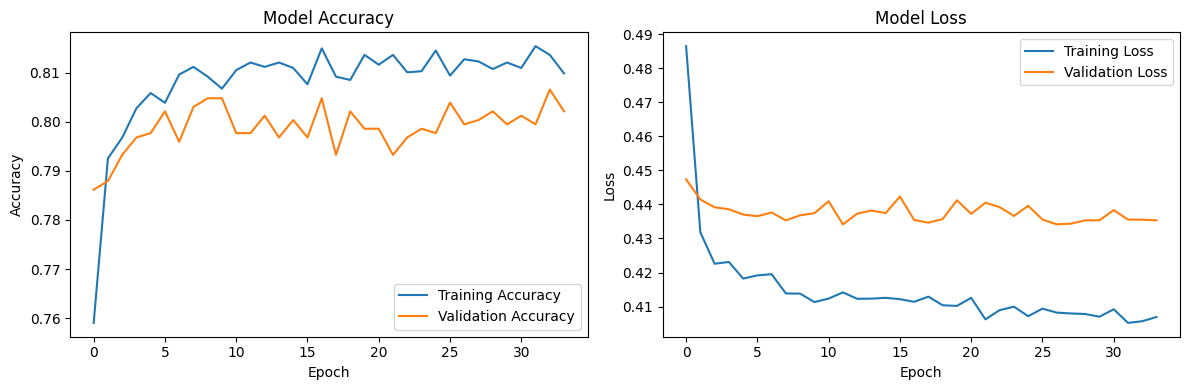

In [ ]:
final_model.save('churn_mlp_model.h5')
print("Model saved as 'churn_mlp_model.h5'")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
import torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.6 MB/s eta 0:00:00


In [ ]:
RANDOM_STATE = 42
target_col = 'churn'
id_cols = [c for c in df.columns if c.lower() in ('customerid','customer_id')]

X = df.drop(columns=[target_col] + id_cols) if id_cols else df.drop(columns=[target_col])
y = df[target_col]

In [ ]:
numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_processed = preprocessor.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)


In [ ]:
X_train_np, X_test_np = X_train.toarray() if hasattr(X_train, 'toarray') else X_train, X_test.toarray() if hasattr(X_test, 'toarray') else X_test
y_train_np, y_test_np = np.array(y_train), np.array(y_test)

tabnet_model = TabNetClassifier(
    n_d=16, n_a=16, n_steps=5,
    gamma=1.3, n_independent=2, n_shared=2,
    lambda_sparse=1e-4, optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    verbose=10, seed=42
)

tabnet_model.fit(
    X_train_np, y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=100, patience=10,
    batch_size=1040, virtual_batch_size=138,
    num_workers=0, drop_last=False
)

y_pred_proba_tabnet = tabnet_model.predict_proba(X_test_np)[:, 1]
y_pred_tabnet = (y_pred_proba_tabnet > 0.5).astype(int)
tabnet_accuracy = accuracy_score(y_test_np, y_pred_tabnet)
tabnet_auc = roc_auc_score(y_test_np, y_pred_proba_tabnet)

print("\nTabNet Performance")
print(classification_report(y_test_np, y_pred_tabnet))


epoch 0  | loss: 1.38766 | train_auc: 0.41075 | valid_auc: 0.41209 |  0:00:01s
epoch 10 | loss: 0.58134 | train_auc: 0.65652 | valid_auc: 0.64723 |  0:00:12s
epoch 20 | loss: 0.50281 | train_auc: 0.76544 | valid_auc: 0.74794 |  0:00:21s
epoch 30 | loss: 0.47371 | train_auc: 0.80172 | valid_auc: 0.78631 |  0:00:31s
epoch 40 | loss: 0.4599  | train_auc: 0.81794 | valid_auc: 0.80943 |  0:00:41s
epoch 50 | loss: 0.44944 | train_auc: 0.82841 | valid_auc: 0.80296 |  0:00:50s

Early stopping occurred at epoch 50 with best_epoch = 40 and best_valid_auc = 0.80943

TabNet Performance
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.61      0.49      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



In [ ]:
models_comparison = {
    'Logistic Regression': {'Accuracy': lr_accuracy, 'AUC': lr_auc},
    'Random Forest': {'Accuracy': rf_accuracy, 'AUC': rf_auc},
    'Neural Network (MLP)': {'Accuracy': test_accuracy, 'AUC': test_auc},
    'TabNet': {'Accuracy': tabnet_accuracy, 'AUC': tabnet_auc}
}


In [ ]:
print("\nModel Performance Comparison:")
print("="*50)
for model, metrics in models_comparison.items():
    print(f"{model}: Accuracy={metrics['Accuracy']:.4f}, AUC={metrics['AUC']:.4f}")



Model Performance Comparison:
Logistic Regression: Accuracy=0.8034, AUC=0.8421
Random Forest: Accuracy=0.7807, AUC=0.8202
Neural Network (MLP): Accuracy=0.7991, AUC=0.8417
TabNet: Accuracy=0.7821, AUC=0.8094


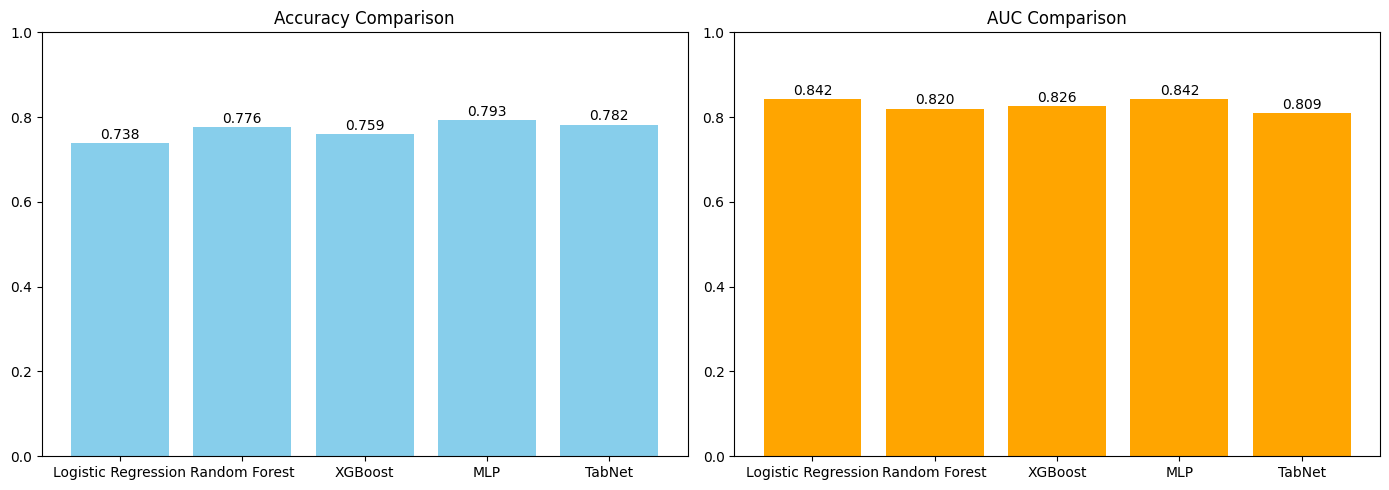

In [198]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


models = [m for m in models_comparison.keys() if m != 'CNN']
accuracies = [models_comparison[m]['Accuracy'] for m in models]
aucs = [models_comparison[m]['AUC'] for m in models]


ax1.bar(models, accuracies, color='skyblue')
ax1.set_title("Accuracy Comparison")
ax1.set_ylim(0, 1)
for i, v in enumerate(accuracies):
    ax1.text(i, v+0.01, f"{v:.3f}", ha='center')


ax2.bar(models, aucs, color='orange')
ax2.set_title("AUC Comparison")
ax2.set_ylim(0, 1)
for i, v in enumerate(aucs):
    ax2.text(i, v+0.01, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()



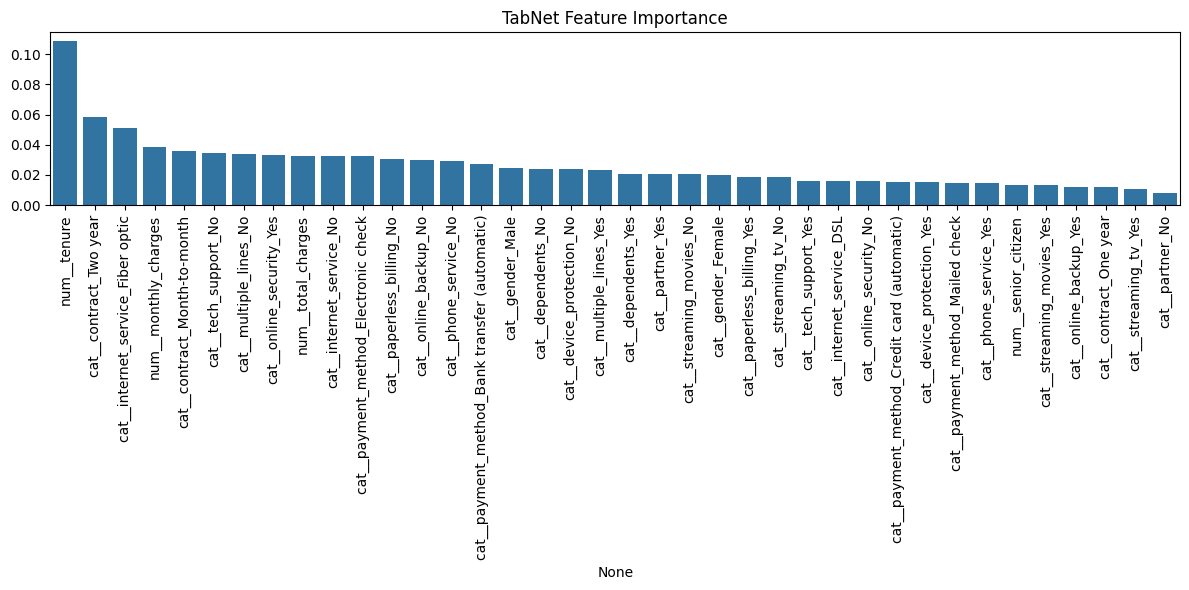

In [ ]:
feature_names = preprocessor.get_feature_names_out(X.columns)

feature_importances = tabnet_model.feature_importances_

feat_imp_series = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12,6))

sns.barplot(x=feat_imp_series.index, y=feat_imp_series.values)
plt.xticks(rotation=90)
plt.title("TabNet Feature Importance")
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.models import Model

In [ ]:
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

In [ ]:
def create_cnn_model(filters=32, kernel_size=3, learning_rate=0.001):
    inputs = Input(shape=(X_train_cnn.shape[1], 1))
    x = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    return model



In [ ]:
cnn_model = create_cnn_model()
early_stop = EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True, verbose=1)

history_cnn = cnn_model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7249 - auc: 0.7072 - loss: 0.5335 - val_accuracy: 0.7879 - val_auc: 0.8111 - val_loss: 0.4498
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7878 - auc: 0.8302 - loss: 0.4331 - val_accuracy: 0.7870 - val_auc: 0.8162 - val_loss: 0.4477
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8077 - auc: 0.8442 - loss: 0.4191 - val_accuracy: 0.7853 - val_auc: 0.8194 - val_loss: 0.4447
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7969 - auc: 0.8406 - loss: 0.4214 - val_accuracy: 0.7977 - val_auc: 0.8208 - val_loss: 0.4410
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8065 - auc: 0.8427 - loss: 0.4190 - val_accuracy: 0.7862 - val_auc: 0.8216 - val_loss: 0.4433
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7986 - auc: 0.8492 - loss: 0.4129 - val_accuracy: 0.7879 - val_auc: 0.8207 - val_loss: 0.4439
Epoch 7/100
141/141 ━━━━━━━━━━━━━━

In [186]:
test_loss_cnn, test_accuracy_cnn, test_auc_cnn = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
y_pred_proba_cnn = cnn_model.predict(X_test_cnn)
y_pred_cnn = (y_pred_proba_cnn > 0.5).astype(int)

print("\nCNN Performance")
print(classification_report(y_test, y_pred_cnn))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

CNN Performance
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.47      0.55       374

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.78      0.80      0.78      1409



In [193]:
models_comparison = {
    'Logistic Regression': {'Accuracy': results['Logistic Regression']['accuracy'], 'AUC': results['Logistic Regression']['auc']},
    'Random Forest': {'Accuracy': results['Random Forest']['accuracy'], 'AUC': results['Random Forest']['auc']},
    'XGBoost': {'Accuracy': results['XGBoost']['accuracy'], 'AUC': results['XGBoost']['auc']},
    'MLP': {'Accuracy': test_accuracy, 'AUC': test_auc},
    'CNN': {'Accuracy': test_accuracy_cnn, 'AUC': test_auc_cnn},
    'TabNet': {'Accuracy': tabnet_accuracy, 'AUC': tabnet_auc}
}

print("\nModel Performance Comparison:")
print("="*50)
for model, metrics in models_comparison.items():
    print(f"{model}: Accuracy={metrics['Accuracy']:.4f}, AUC={metrics['AUC']:.4f}")


Model Performance Comparison:
Logistic Regression: Accuracy=0.7381, AUC=0.8416
Random Forest: Accuracy=0.7757, AUC=0.8201
XGBoost: Accuracy=0.7594, AUC=0.8258
MLP: Accuracy=0.7928, AUC=0.8423
CNN: Accuracy=0.7963, AUC=0.8407
TabNet: Accuracy=0.7821, AUC=0.8094


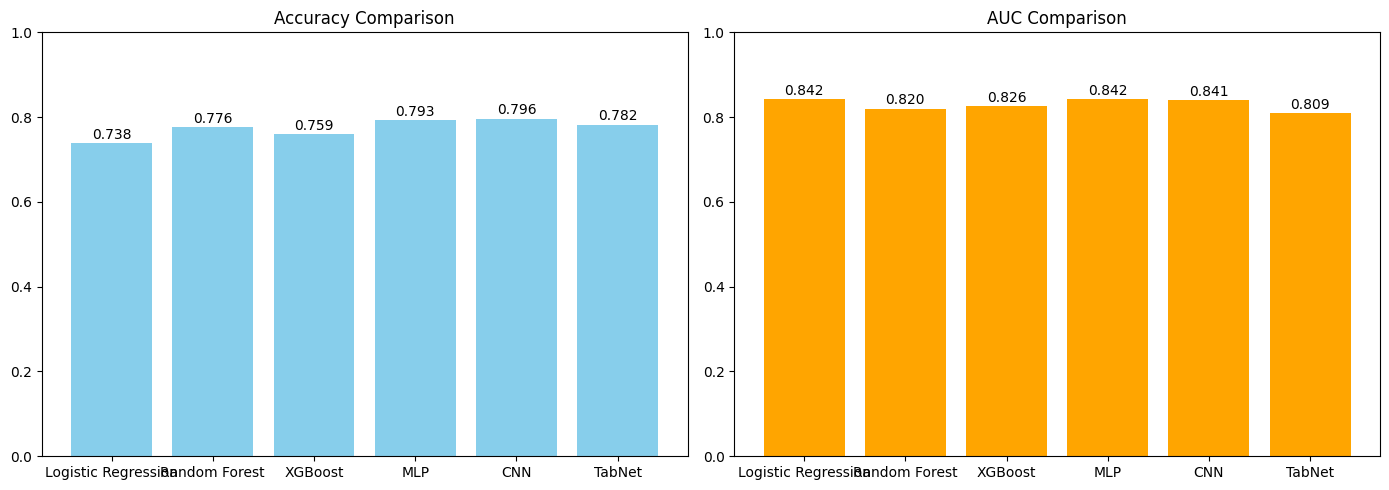

In [200]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
models = list(models_comparison.keys())
accuracies = [metrics['Accuracy'] for metrics in models_comparison.values()]
aucs = [metrics['AUC'] for metrics in models_comparison.values()]

ax1.bar(models, accuracies, color='skyblue')
ax1.set_title("Accuracy Comparison")
ax1.set_ylim(0, 1)
for i,v in enumerate(accuracies):
    ax1.text(i, v+0.01, f"{v:.3f}", ha='center')

ax2.bar(models, aucs, color='orange')
ax2.set_title("AUC Comparison")
ax2.set_ylim(0, 1)
for i,v in enumerate(aucs):
    ax2.text(i, v+0.01, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.show()

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
45/45 ━━━━━━━━━━━━━━━━━━━

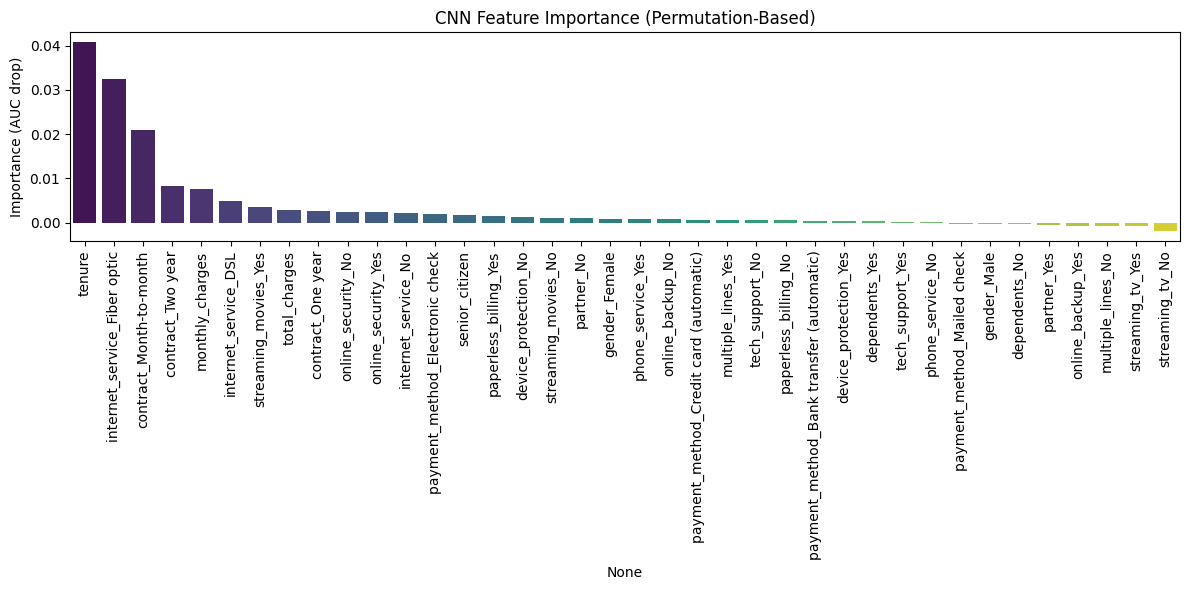

In [208]:
from sklearn.metrics import roc_auc_score
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


X_test_cnn_reshaped = np.expand_dims(X_test, axis=2)


baseline_proba = cnn_model.predict(X_test_cnn_reshaped)
baseline_auc = roc_auc_score(y_test, baseline_proba)



numeric_feature_names = numeric_cols

onehot_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)

feature_names = list(numeric_feature_names) + list(onehot_feature_names)


feature_importances = {}


for i, feature in enumerate(feature_names):

    X_test_permuted = copy.deepcopy(X_test)


    np.random.shuffle(X_test_permuted[:, i])


    X_test_permuted_cnn = np.expand_dims(X_test_permuted, axis=2)


    permuted_proba = cnn_model.predict(X_test_permuted_cnn)


    permuted_auc = roc_auc_score(y_test, permuted_proba)


    feature_importances[feature] = baseline_auc - permuted_auc


feat_imp_series = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)


plt.figure(figsize=(12,6))
sns.barplot(x=feat_imp_series.index, y=feat_imp_series.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("CNN Feature Importance (Permutation-Based)")
plt.ylabel("Importance (AUC drop)")
plt.tight_layout()
plt.show()